## SNR - fig2_Difference Cumulative Plots

In [1]:
import time, datetime
import numpy as np
from numpy import zeros, sqrt, pi, vectorize
from numpy.linalg import pinv, inv
from multiprocessing import Process, Queue
#import matplotlib
#matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from error_analysis_class import *
from noshellavg import *

## Initial settings 

In [2]:
def BandPowerFisher(RSDPower, RMIN = 0.1, RMAX = 180, kmin = 0.001, kmax = 2):

    #RMAX = RSDPower.RMAX
    #RMIN = RSDPower.RMIN
    
    rcut_max = get_closest_index_in_data( RMAX, RSDPower.rmax )
    rcut_min = get_closest_index_in_data( RMIN, RSDPower.rmin )
    
    print kmin, RSDPower.kmin_y
    
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )
    
    print 'rcut_min, rcut_max ', RSDPower.rmax[rcut_min], RSDPower.rmin[rcut_max]
    
    file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
    RSDPower.MatterPower(file = file)
    # power spectrum multipoles l = 0,2,4
    RSDPower.multipole_P_band_all()

    # derivative dXi/dp
    RSDPower.derivative_Xi_band_all()

    # P covariance matrix ( nine submatrices C_ll' )
    RSDPower.RSDband_covariance_PP_all()

    # Xi covariance matrix ( nine submatrices C_ll' )
    RSDPower.covariance_Xi_all()
    RSDPower.covariance_PXi_All()


    matricesXi = [RSDPower.covariance00[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance22[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              np.transpose(RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance44[rcut_max:rcut_min+1,rcut_max:rcut_min+1]]

    matricesPP_all = [RSDPower.covariance_PP00,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP22,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP44]

    matricesPP = [RSDPower.covariance_PP00[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP22[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP44[kcut_min:kcut_max+1,kcut_min:kcut_max+1]]

    matricesPXi = [RSDPower.covariance_PXi00[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi02[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi04[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi20[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi22[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi24[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi40[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi42[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi44[kcut_min:kcut_max+1,rcut_max:rcut_min+1]]


    l1 = RSDPower.kcenter_y.size
    l2 = rcut_min+1 - rcut_max
    l3 = kcut_max+1 - kcut_min
    
    
    # combining covariances
    C_matrix3PP_all = CombineCovariance3(l1, matricesPP_all)
    C_matrix3PP = CombineCovariance3(l3, matricesPP)
    C_matrix3Xi = CombineCovariance3(l2, matricesXi)

    #C_matrix3PXi = np.zeros((C_matrix3PXi.shape))
    C_matrix3PXi, C_matrix3XiP = CombineCrossCovariance3(l3, l2, matricesPXi, transpose = True)
    C_matrix3_tot = np.concatenate((np.concatenate((C_matrix3PP, C_matrix3PXi), axis=1),\
                                    np.concatenate((C_matrix3PXi.T, C_matrix3Xi), axis=1)), axis = 0)


    
    # inverting matrices
    from test_SNR import blockwiseInversion
    FisherP_all = inv(C_matrix3PP_all)
    FisherP = inv(C_matrix3PP)
    FisherXi = blockwiseInversion( C_matrix3Xi, rcut_min+1-rcut_max )
    Fisher3_tot = blockwiseInversion( C_matrix3_tot, 3 * (kcut_max+1-kcut_min) )
    
    
    # derivatives
    derivative_P0 = np.identity(RSDPower.kcenter_y.size)[:,kcut_min:kcut_max+1]
    Pzeros = np.zeros((derivative_P0.shape))

    derivative_P = np.concatenate((np.concatenate((derivative_P0, Pzeros, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, derivative_P0, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, Pzeros, derivative_P0),axis=1 )), axis=0)
    Xizeros = np.zeros((RSDPower.dxip0[:,rcut_max:rcut_min+1].shape))
    derivative_correl_avg = np.concatenate(( np.concatenate((RSDPower.dxip0[:,rcut_max:rcut_min+1],Xizeros,Xizeros), axis=1),\
                                            np.concatenate((Xizeros,RSDPower.dxip2[:,rcut_max:rcut_min+1],Xizeros), axis=1),\
                                            np.concatenate((Xizeros,Xizeros,RSDPower.dxip4[:,rcut_max:rcut_min+1]), axis=1)),axis=0 )
    Derivatives = np.concatenate((derivative_P,derivative_correl_avg), axis=1)

    
    # Fisher.....
    FisherBand_P = FisherP.copy()
    FisherBand_P_all = FisherP_all.copy()
    FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
    FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)
    
    
    # vector and reorder
    from test_SNR import reorderingVector, reordering, blockwise
    m_P0 = RSDPower.multipole_bandpower0[kcut_min:kcut_max+1]
    m_P2 = RSDPower.multipole_bandpower2[kcut_min:kcut_max+1]
    m_P4 = RSDPower.multipole_bandpower4[kcut_min:kcut_max+1]
    m_P = reorderingVector( [m_P0, m_P2, m_P4] )
    # Fisher reorering
    re_FisherBand_P_all, _ = reordering( RSDPower, FisherBand_P_all)
    re_FisherBand_P, _ = reordering( RSDPower, FisherBand_P)
    re_FisherBand_Xi, m_P_all = reordering( RSDPower, FisherBand_Xi)
    re_FisherBand_tot, _ = reordering( RSDPower, FisherBand_tot)

    return m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot

In [3]:
def BandPowerFisher_P(RSDPower, kmin = 0.01, kmax = 2):
    
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y ) 
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )
    
    print 'kcut_min, kcut_max ', RSDPower.kmin_y[kcut_min], RSDPower.kmax_y[kcut_max]
    
    file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
    RSDPower.MatterPower(file = file)
    # power spectrum multipoles l = 0,2,4
    RSDPower.multipole_P_band_all()

    # derivative dXi/dp
    #RSDPower.derivative_Xi_band_all()

    # P covariance matrix ( nine submatrices C_ll' )
    RSDPower.RSDband_covariance_PP_all()

    # Xi covariance matrix ( nine submatrices C_ll' )
    #RSDPower.covariance_Xi_all()
    #RSDPower.covariance_PXi_All()



    matricesPP_all = [RSDPower.covariance_PP00,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP22,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP44]

    matricesPP = [RSDPower.covariance_PP00[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP22[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP44[kcut_min:kcut_max+1,kcut_min:kcut_max+1]]


    l1 = RSDPower.kcenter_y.size
    l3 = kcut_max+1 - kcut_min
    
    
    # combining covariances
    C_matrix3PP_all = CombineCovariance3(l1, matricesPP_all)
    #C_matrix3PP = CombineCovariance3(l3, matricesPP)
    
    # inverting matrices
    from test_SNR import blockwiseInversion
    FisherP_all = inv(C_matrix3PP_all)
    #FisherP = inv(C_matrix3PP)   
    
    # derivatives
    derivative_P0 = np.identity(RSDPower.kcenter_y.size)[:,kcut_min:kcut_max+1]
    Pzeros = np.zeros((derivative_P0.shape))

    derivative_P = np.concatenate((np.concatenate((derivative_P0, Pzeros, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, derivative_P0, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, Pzeros, derivative_P0),axis=1 )), axis=0)

    
    # Fisher.....
    #FisherBand_P = FisherP.copy()
    FisherBand_P_all = FisherP_all.copy()
    
    
    # vector and reorder
    from test_SNR import reorderingVector, reordering, blockwise
    m_P0 = RSDPower.multipole_bandpower0[kcut_min:kcut_max+1]
    m_P2 = RSDPower.multipole_bandpower2[kcut_min:kcut_max+1]
    m_P4 = RSDPower.multipole_bandpower4[kcut_min:kcut_max+1]
    m_P = reorderingVector( [m_P0, m_P2, m_P4] )
    # Fisher reorering
    re_FisherBand_P_all, m_P_all = reordering( RSDPower, FisherBand_P_all)
    #re_FisherBand_P, _ = reordering( RSDPower, FisherBand_P)

    return m_P_all, re_FisherBand_P_all

In [4]:
def BandPowerFisher_Xi(RSDPower, RMIN = 0.1, RMAX = 180, kmin = 0.001, kmax = 2):
    
    #RMAX = RSDPower.RMAX
    #RMIN = RSDPower.RMIN
    
    rcut_max = get_closest_index_in_data( RMAX, RSDPower.rmax )
    rcut_min = get_closest_index_in_data( RMIN, RSDPower.rmin )
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )
    
    print 'rcut_min, rcut_max ', RSDPower.rmax[rcut_min], RSDPower.rmin[rcut_max]
    
    file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
    RSDPower.MatterPower(file = file)
    # power spectrum multipoles l = 0,2,4
    RSDPower.multipole_P_band_all()

    # derivative dXi/dp
    RSDPower.derivative_Xi_band_all()

    # P covariance matrix ( nine submatrices C_ll' )
    #RSDPower.RSDband_covariance_PP_all()

    # Xi covariance matrix ( nine submatrices C_ll' )
    RSDPower.covariance_Xi_all()
    #RSDPower.covariance_PXi_All()


    matricesXi = [RSDPower.covariance00[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance22[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              np.transpose(RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance44[rcut_max:rcut_min+1,rcut_max:rcut_min+1]]

    l1 = RSDPower.kcenter_y.size
    l2 = rcut_min+1 - rcut_max
    l3 = kcut_max+1 - kcut_min

    C_matrix3Xi = CombineCovariance3(l2, matricesXi)

    
    # inverting matrices
    from test_SNR import blockwiseInversion
    FisherXi = blockwiseInversion( C_matrix3Xi, rcut_min+1-rcut_max )
    
    
    # derivatives

    Xizeros = np.zeros((RSDPower.dxip0[:,rcut_max:rcut_min+1].shape))
    derivative_correl_avg = np.concatenate(( np.concatenate((RSDPower.dxip0[:,rcut_max:rcut_min+1],Xizeros,Xizeros), axis=1),\
                                            np.concatenate((Xizeros,RSDPower.dxip2[:,rcut_max:rcut_min+1],Xizeros), axis=1),\
                                            np.concatenate((Xizeros,Xizeros,RSDPower.dxip4[:,rcut_max:rcut_min+1]), axis=1)),axis=0 )
   
    FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)

    
    # vector and reorder
    from test_SNR import reorderingVector, reordering, blockwise

    re_FisherBand_Xi, m_P_all = reordering( RSDPower, FisherBand_Xi)

    return m_P_all, re_FisherBand_Xi
    
    

----

## Signal to Noise

SNR = $\sum_{i,j} P_i ~F_{P} ~P_j$  

Reordering vectors and Multipoles

### Delta Cumulative Sinal to Noise

$\Delta~\sum (S/N)^2$

In [5]:
def DeltaCumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kmin, kmax):
    
    from test_SNR import blockwise
    
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )

    FP = re_FisherBand_P_all.copy()[3*kcut_min:3*kcut_max+3, 3*kcut_min:3*kcut_max+3]
    PP = m_P_all.copy()[3*kcut_min:3*kcut_max+3]
    
    SNRlist_P = []
    SNRP = np.dot( np.dot(PP, FP), PP.T )
    SNRlist_P.append(SNRP)
    for j in range(1, PP.size/3):
        PP = PP[:-3]
        for i in range(0,3):
            FP = blockwise( FP )
        SNRP = np.dot( np.dot(PP, FP), PP.T )
        SNRlist_P.append(SNRP)

    SNRlist_P = np.array(SNRlist_P[::-1]).ravel()
    kklist = RSDPower.kcenter_y[kcut_min:kcut_max+1]
    
    return kklist, SNRlist_P

In [6]:
#  (parameter description in class code)
# Fourier K 0.001~10
KMIN = 0.01
KMAX = 2 # 361.32 #502.32
RMIN = 0.1
RMAX = 180

kmin = 0.01
kmax = 2

# the number of k sample point should be 2^n+1 (b/c romb integration)
rN = 300
kN = 1
kN_x = 2**13 + 1
kN_y = 500
#subN = 2**5 + 1
# RSD class

Plotting

In [7]:
RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, 500, logscale = False)
m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot \
= BandPowerFisher(RSDPower)

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 500, rN = 300
dr = 0.601672240803, dk=nan, dk_y=0.0039879759519
0.001 [ 0.01        0.01398798  0.01797595  0.02196393  0.0259519   0.02993988
  0.03392786  0.03791583  0.04190381  0.04589178  0.04987976  0.05386774
  0.05785571  0.06184369  0.06583166  0.06981964  0.07380762  0.07779559
  0.08178357  0.08577154  0.08975952  0.09374749  0.09773547  0.10172345
  0.10571142  0.1096994   0.11368737  0.11767535  0.12166333  0.1256513
  0.12963928  0.13362725  0.13761523  0.14160321  0.14559118  0.14957916
  0.15356713  0.15755511  0.16154309  0.16553106  0.16951904  0.17350701
  0.17749499  0.18148297  0.18547094  0.18945892  0.19344689  0.19743487
  0.20142285  0.20541082  0.2093988   0.21338677  0.21737475  0.22136273
  0.2253507   0.22933868  0.23332665  0.23731463  0.24130261  0.24529058
  0.24927856  0.25326653  0.25725451  0.26124248  0.26523046  0.2

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
print re_FisherBand_P_all.max(), re_FisherBand_P_all.min()
print re_FisherBand_Xi.max(), re_FisherBand_Xi.min()
print np.sum(re_FisherBand_P_all), np.sum(re_FisherBand_Xi)

fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize = (20, 10))
ax.imshow(np.log10(re_FisherBand_P_all), interpolation = 'none')
ax2.imshow(np.log10(re_FisherBand_Xi),interpolation = 'none' )#, vmin=re_FisherBand_P_all.min(), vmax=re_FisherBand_P_all.max())
ax3.imshow(np.log10(re_FisherBand_tot),interpolation = 'none')#, vmin=re_FisherBand_P_all.min(), vmax=re_FisherBand_P_all.max())

In [ ]:
rmin = 30
rmax = 180
rn = int((rmax - rmin) * 300/180)
RSDPower3 = NoShell_covariance(KMIN, KMAX, rmin, rmax, kN, rn, kN_x, 500, logscale = False)
m_P3, m_P_all3, re_FisherBand_P_all3,re_FisherBand_P3, re_FisherBand_Xi3, re_FisherBand_tot3 \
= BandPowerFisher(RSDPower3)

In [ ]:
print re_FisherBand_P_all3.max(), re_FisherBand_P_all3.min()
print re_FisherBand_Xi3.max(), re_FisherBand_Xi3.min()
print np.sum(re_FisherBand_P_all3), np.sum(re_FisherBand_Xi3)

fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize = (20, 10))
ax.imshow(np.log10(re_FisherBand_P_all3), interpolation = 'none')
ax2.imshow(np.log10(re_FisherBand_Xi3),interpolation = 'none' )#, vmin=re_FisherBand_P_all.min(), vmax=re_FisherBand_P_all.max())
ax3.imshow(np.log10(re_FisherBand_tot3),interpolation = 'none')#, vmin=re_FisherBand_P_all.min(), vmax=re_FisherBand_P_all.max())

In [ ]:
ks_list = []
SNRs_list = []
ks_list3 = []
SNRs_list3 = []

ks_x_list = []
SNRXis_list = []
ks_x_list3 = []
SNRXis_list3 = []

kkk = np.linspace(KMIN, KMAX, 10)

for i in range(kkk.size -1):   
    
    ks, SNRs = DeltaCumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kkk[i], kkk[i+1])
    ks_x, SNRXis = DeltaCumulativeSNR(RSDPower, re_FisherBand_Xi, m_P_all, kkk[i], kkk[i+1])
    ks_x_list.append(ks_x)
    SNRXis_list.append(SNRXis)
    ks_list.append(ks)
    SNRs_list.append(SNRs)


kkk2 = np.linspace(KMIN, KMAX, 10)
for i in range(kkk2.size -1):  
    
    ks, SNRs = DeltaCumulativeSNR(RSDPower3, re_FisherBand_P_all3, m_P_all3, kkk2[i], kkk2[i+1])
    ks_x, SNRXis = DeltaCumulativeSNR(RSDPower3, re_FisherBand_Xi3, m_P_all3, kkk2[i], kkk2[i+1])
    ks_x_list3.append(ks_x)
    SNRXis_list3.append(SNRXis)
    ks_list3.append(ks)
    SNRs_list3.append(SNRs)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

#kkk = np.logspace(np.log10(KMIN), np.log10(KMAX), 10)

DAT = np.loadtxt('data_txt/snr_p.txt')
ks, SNRs = DAT[:,0], DAT[:,1]
#ax.plot(ks, SNRs, linestyle='-.', color = 'black', label = 'theory, p' )

for i in range(kkk.size -1):   
    ax.plot(ks_list[i], SNRs_list[i]/ks_list[i]**2,'k-', label = 'P (r 0.1-180)' ) 
    ax.plot(ks_x_list[i], SNRXis_list[i]/ks_x_list[i]**2,'k.', label = 'Xi (r 0.1-180)' ) 
    #ax.plot(ks_list3[i], SNRs_list3[i]/ks_list3[i]**2,'b-', label = 'P (r 30-180)' ) 
    ax.plot(ks_x_list3[i], SNRXis_list3[i]/ks_x_list3[i]**2,'b.', label = 'Xi (r 30-180)' ) 

ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('k (h/Mpc)')
ax.set_ylabel('Delta (SNR Xi)^2 / k^2')
ax.set_title('Solid: P, black dot: Xi (r 0.1-180), blue dot: Xi (r 30-180)')
ax.set_xlim(0,1)
ax.set_ylim(1e1, 1e7)
#ax.legend(loc='best')
figname = 'figure/DeltaSNR.png'
fig.savefig(figname)
print 'fig save to ',figname

In [ ]:
RSDPower6 = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, 500, logscale = False)
m_P_all, re_FisherBand_Xi = BandPowerFisher_Xi(RSDPower6, RMIN = rn, RMAX = rx, kmin = KMIN, kmax = KMAX)

In [ ]:
RSDPower6 = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, 500, logscale = False)
#m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot \
#= BandPowerFisher(RSDPower)

In [ ]:
RSDPower6 = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, kN_y, logscale = False)
m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot \
= BandPowerFisher(RSDPower)
m_P_all_xi, re_FisherBand_Xi_xi =\
BandPowerFisher_Xi(RSDPower6, RMIN = rrr1[i], RMAX =rrr2[i] , kmin = kmin, kmax = kmax)

## fix starting point r

In [ ]:
#kkk2 = np.logspace(np.log10(KMIN), np.log10(KMAX), 50)
#kkk2 = np.linspace(KMIN, KMAX, 3)

#DAT = np.loadtxt('data_txt/snr_p.txt')
#ks, SNRs = DAT[:,0], DAT[:,1]
#ax.plot(ks, SNRs, linestyle='-.', color = 'black', label = 'theory, p' )

#rrr = np.linspace(RMIN, RMAX, 10)

In [330]:
rrr1 = np.linspace(.1, 180, 7)
rrr1 = np.insert(rrr1, 1, 2.0)

ks_x_list = []
SNRXis_list = []
sum_list = []
for i in range(rrr1.size -1):    
    fixrn = int(1000./200 * (rrr1[i+1] - rrr1[0]))
    RSDPower6 = NoShell_covariance(KMIN, KMAX, rrr1[0], rrr1[i + 1], kN, fixrn, kN_x, 70, logscale = False)
    m_P_all_xi, re_FisherBand_Xi =\
    BandPowerFisher_Xi(RSDPower6, RMIN = rrr1[0], RMAX =rrr1[i + 1] , kmin = kmin, kmax = kmax)
    ks_x, SNRXis = DeltaCumulativeSNR(RSDPower6, re_FisherBand_Xi, m_P_all_xi, kmin, kmax)
    sum_list.append(np.sum(re_FisherBand_Xi))
    ks_x_list.append(ks_x)
    SNRXis_list.append(SNRXis)
    #ax.plot(ks, SNRs/ks**2, linestyle='--', color = 'blue' )

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 9, N_x = 8193
dr = 0.2375, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.3375 1.7625


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 149, N_x = 8193
dr = 0.20259009009, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.30259009009 29.8807432432


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 299, N_x = 8193
dr = 0.201230425056, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.301230425056 59.8654362416


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 449, N_x = 8193
dr = 0.20078125, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.30078125 89.84921875


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 599, N_x = 8193
dr = 0.200557413601, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.300557413601 119.83277592


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 749, N_x = 8193
dr = 0.200423351159, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.300423351159 149.816243316


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 899, N_x = 8193
dr = 0.200334075724, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.300334075724 179.799665924


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

fig save to  figure/DeltaSNR_r.png


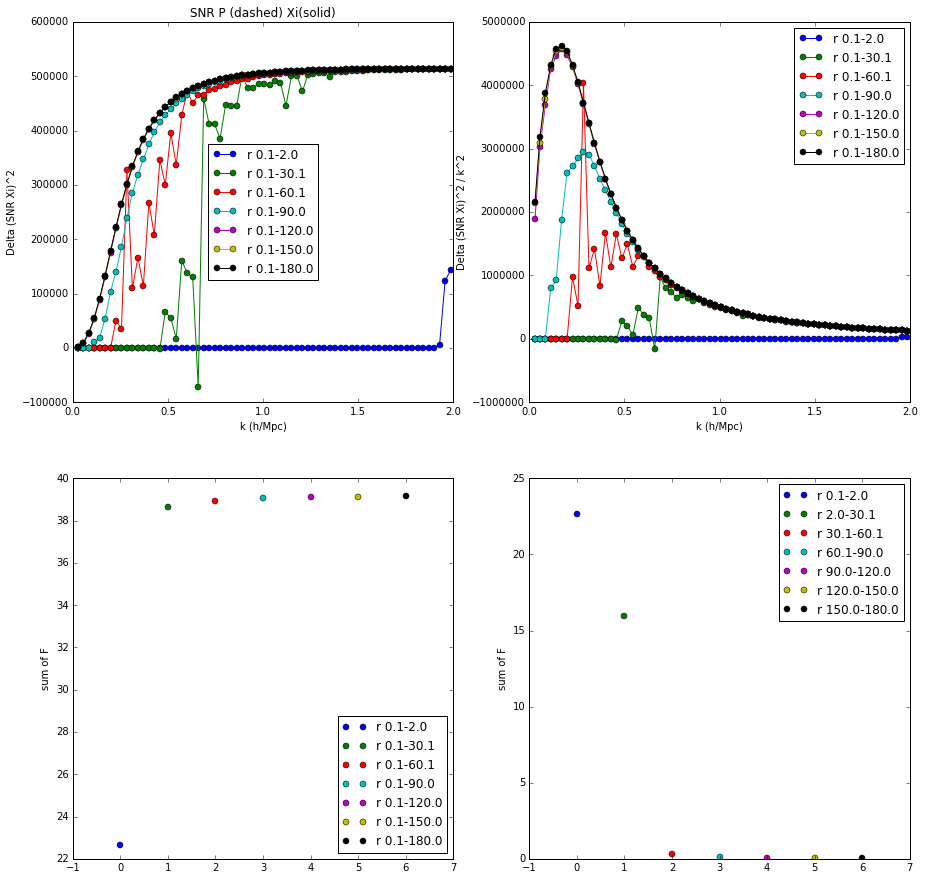

In [333]:

sum_list_bin = sum_list - np.insert(sum_list[:-1], 0, 0)

fig, ((ax, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
for i in range(rrr1.size-1):
    ax.plot(ks_x_list[i], SNRXis_list[i], 'o-', label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[0], rrr1[i+1])) #ax.lines[-1].get_color())
    ax2.plot(ks_x_list[i], SNRXis_list[i]/ks_x_list[i]**2, 'o-', label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[0], rrr1[i+1]))    
    ax3.plot(i, sum_list[i], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[0], rrr1[i+1]))
    ax4.plot(i, sum_list_bin[i], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
#for j in range(rrr1.size/2, rrr1.size-1):
#    ax2.plot(ks_x_list[j], SNRXis_list[j]/ks_x_list[j]**2/SNRXis_list[j].max(), 'o-', label = 'r {}-{}'.format(rrr1[j], rrr2[j]))

#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('k (h/Mpc)')
ax2.set_xlabel('k (h/Mpc)')
ax.set_ylabel('Delta (SNR Xi)^2')
ax2.set_ylabel('Delta (SNR Xi)^2 / k^2')
ax3.set_ylabel('sum of F')
ax4.set_ylabel('sum of F')
ax.set_title('SNR P (dashed) Xi(solid)')
ax2.set_title('')
ax.set_xlim(0,2)
#ax2.set_xlim(1,2)
#ax.set_ylim(0,40000)
#ax2.set_ylim(0,.5)
ax3.set_xlim(-1,i+1)
ax4.set_xlim(-1,i+1)
ax.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
ax4.legend(loc='best')
figname = 'figure/DeltaSNR_r.png'
fig.savefig(figname)
print 'fig save to ',figname

## fix the size of r range

In [85]:
rrr1 = np.linspace(.1, 200, 5)

ks_x_list = []
SNRXis_list = []
sum_list = []
for i in range(rrr1.size -1):    
    fixrn = int(500/200 * (rrr1[i+1] - rrr1[i]))
    RSDPower6 = NoShell_covariance(KMIN, KMAX, rrr1[i], rrr1[i + 1], kN, fixrn, kN_x, 70, logscale = False)
    m_P_all_xi, re_FisherBand_Xi =\
    BandPowerFisher_Xi(RSDPower6, RMIN = rrr1[i], RMAX =rrr1[i + 1] , kmin = kmin, kmax = kmax)
    ks_x, SNRXis = DeltaCumulativeSNR(RSDPower6, re_FisherBand_Xi, m_P_all_xi, kmin, kmax)
    sum_list.append(np.sum(re_FisherBand_Xi))
    ks_x_list.append(ks_x)
    SNRXis_list.append(SNRXis)
    #ax.plot(ks, SNRs/ks**2, linestyle='--', color = 'blue' )

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 99, N_x = 8193
dr = 0.509948979592, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.609948979592 49.5650510204


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 99, N_x = 8193
dr = 0.509948979592, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  50.5849489796 99.5400510204


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 99, N_x = 8193
dr = 0.509948979592, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  100.55994898 149.51505102


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 99, N_x = 8193
dr = 0.509948979592, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  150.53494898 199.49005102


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


fig save to  figure/DeltaSNR_fixRrange.png


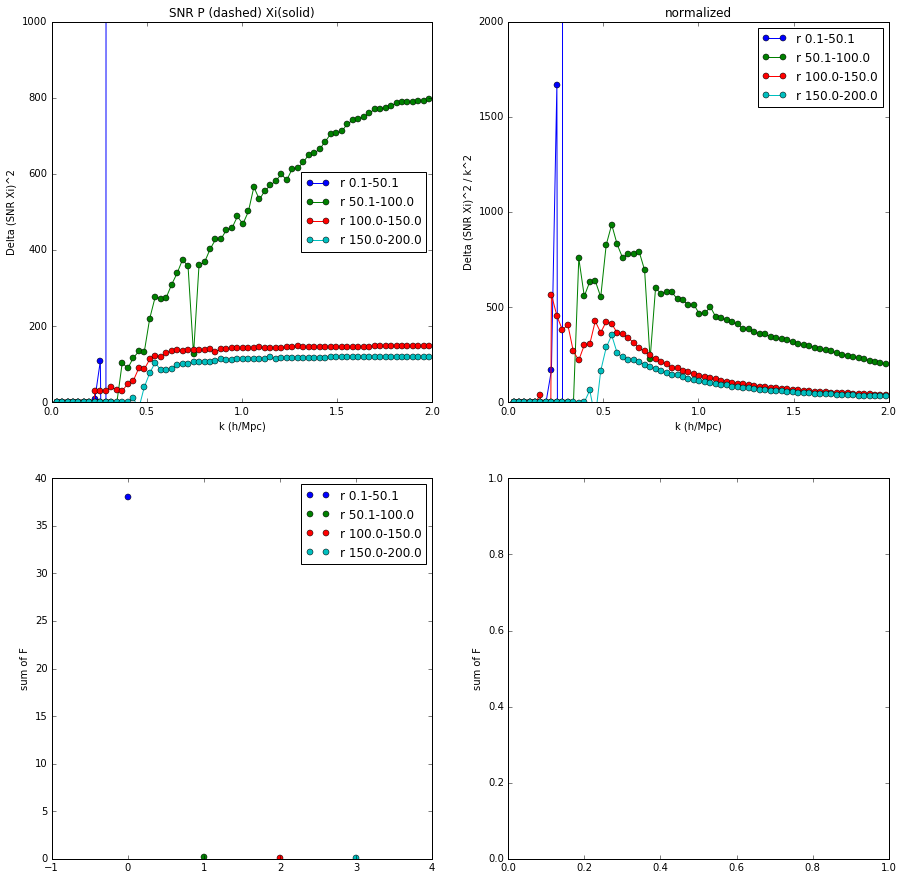

In [91]:

#sum_list_bin = sum_list - np.insert(sum_list[:-1], 0, 0)

fig, ((ax, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
for i in range(0, rrr1.size-1):
    ax.plot(ks_x_list[i], SNRXis_list[i], 'o-', label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1])) #ax.lines[-1].get_color())
    ax2.plot(ks_x_list[i], SNRXis_list[i]/ks_x_list[i]**2, 'o-', label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))    
    ax3.plot(i, sum_list[i], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
    #ax4.plot(i, sum_list_bin[i], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
#for j in range(rrr1.size/2, rrr1.size-1):
#    ax2.plot(ks_x_list[j], SNRXis_list[j]/ks_x_list[j]**2/SNRXis_list[j].max(), 'o-', label = 'r {}-{}'.format(rrr1[j], rrr2[j]))

#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('k (h/Mpc)')
ax2.set_xlabel('k (h/Mpc)')
ax.set_ylabel('Delta (SNR Xi)^2')
ax2.set_ylabel('Delta (SNR Xi)^2 / k^2')
ax3.set_ylabel('sum of F')
ax4.set_ylabel('sum of F')
ax.set_title('SNR P (dashed) Xi(solid)')
ax2.set_title('normalized')
ax.set_xlim(0,2)
#ax2.set_xlim(1,2)
ax.set_ylim(0,1000)
ax2.set_ylim(0,2000)
ax3.set_xlim(-1,i+1)
#ax4.set_xlim(-1,i+1)
ax.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
#ax4.legend(loc='best')
figname = 'figure/DeltaSNR_fixRrange.png'
fig.savefig(figname)
print 'fig save to ',figname

## on small scale

#### 1) rbin size 2

In [123]:
rrr1 = np.linspace(.01, 20, 11)
print rrr1

KMAX = 2.0
kmax = KMAX

ks_x_list = []
SNRXis_list = []
sum_list = []
for i in range(rrr1.size -1):    
    fixrn = int(5000/200 * (rrr1[i+1] - rrr1[i]))
    RSDPower6 = NoShell_covariance(KMIN, KMAX, rrr1[i], rrr1[i + 1], kN, fixrn, kN_x, 70, logscale = False)
    m_P_all_xi, re_FisherBand_Xi =\
    BandPowerFisher_Xi(RSDPower6, RMIN = rrr1[i], RMAX =rrr1[i + 1] , kmin = kmin, kmax = kmax)
    ks_x, SNRXis = DeltaCumulativeSNR(RSDPower6, re_FisherBand_Xi, m_P_all_xi, kmin, kmax)
    sum_list.append(np.sum(re_FisherBand_Xi))
    ks_x_list.append(ks_x)
    SNRXis_list.append(SNRXis)
    #ax.plot(ks, SNRs/ks**2, linestyle='--', color = 'blue' )

[  1.00000000e-02   2.00900000e+00   4.00800000e+00   6.00700000e+00
   8.00600000e+00   1.00050000e+01   1.20040000e+01   1.40030000e+01
   1.60020000e+01   1.80010000e+01   2.00000000e+01]
-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.0516458333333 1.96735416667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  2.05064583333 3.96635416667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  4.04964583333 5.96535416667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  6.04864583333 7.96435416667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  8.04764583333 9.96335416667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  10.0466458333 11.9623541667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  12.0456458333 13.9613541667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  14.0446458333 15.9603541667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  16.0436458333 17.9593541667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 49, N_x = 8193
dr = 0.0416458333333, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  18.0426458333 19.9583541667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


fig save to  figure/DeltaSNR_fixRrange.png


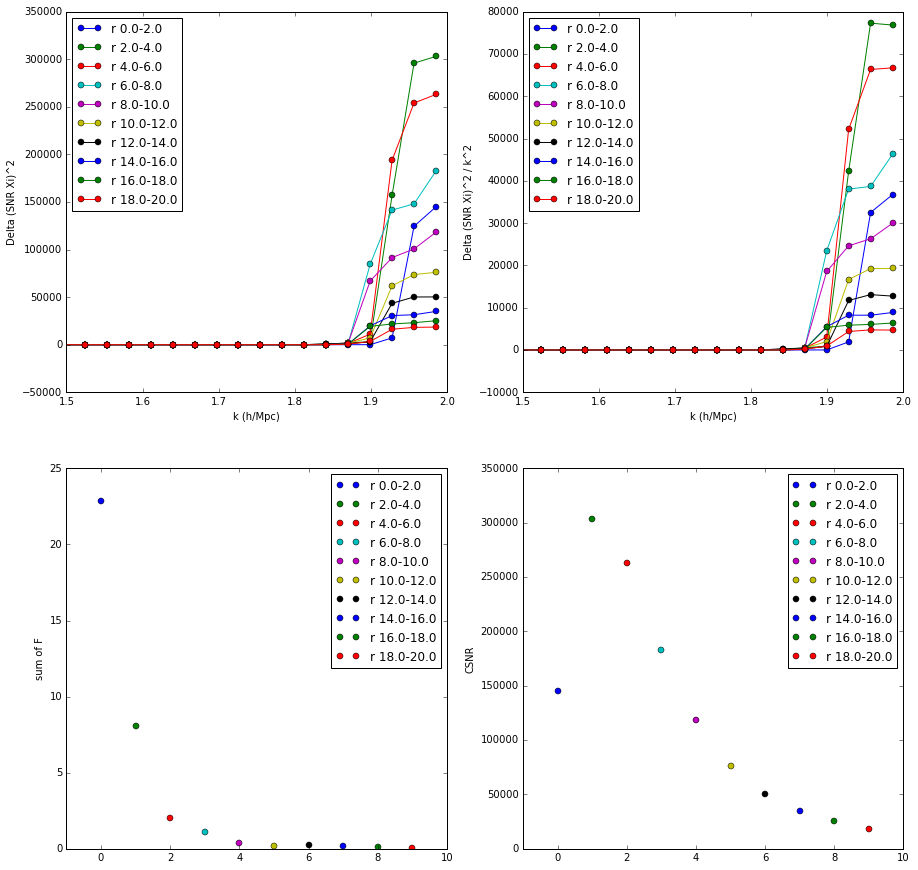

In [126]:
fig, ((ax, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
for i in range(0, rrr1.size-1):
    ax.plot(ks_x_list[i], SNRXis_list[i], 'o-', label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1])) #ax.lines[-1].get_color())
    ax2.plot(ks_x_list[i], SNRXis_list[i]/ks_x_list[i]**2, 'o-', label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))    
    ax3.plot(i, sum_list[i], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
    ax4.plot(i, SNRXis_list[i][-1], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
#for j in range(rrr1.size/2, rrr1.size-1):
#    ax2.plot(ks_x_list[j], SNRXis_list[j]/ks_x_list[j]**2/SNRXis_list[j].max(), 'o-', label = 'r {}-{}'.format(rrr1[j], rrr2[j]))

#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('k (h/Mpc)')
ax2.set_xlabel('k (h/Mpc)')
ax.set_ylabel('Delta (SNR Xi)^2')
ax2.set_ylabel('Delta (SNR Xi)^2 / k^2')
ax3.set_ylabel('sum of F')
ax4.set_ylabel('CSNR')
ax.set_title('')
ax2.set_title('')
ax.set_xlim(1.5,2)
ax2.set_xlim(1.5,2)
#ax.set_ylim(0,1000)
#ax2.set_ylim(0,2000)
ax3.set_xlim(-1,i+1)
ax4.set_xlim(-1,i+1)
ax.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
ax4.legend(loc='best')
figname = 'figure/DeltaSNR_fixRrange.png'
fig.savefig(figname)
print 'fig save to ',figname

#### 2) rbin size 5

In [338]:
rrr1 = np.linspace(1.0, 50, 100)
print rrr1

KMAX = 2.0
kmax = KMAX

ks_x_list = []
SNRXis_list = []
sum_list = []
for i in range(rrr1.size -1):    
    fixrn = 5 #int(1000/200 * (rrr1[i+1] - rrr1[i]))
    RSDPower6 = NoShell_covariance(KMIN, KMAX, rrr1[i], rrr1[i + 1], kN, fixrn, kN_x, 100, logscale = False)
    m_P_all_xi, re_FisherBand_Xi =\
    BandPowerFisher_Xi(RSDPower6, RMIN = rrr1[i], RMAX =rrr1[i + 1] , kmin = kmin, kmax = kmax)
    ks_x, SNRXis = DeltaCumulativeSNR(RSDPower6, re_FisherBand_Xi, m_P_all_xi, kmin, kmax)
    sum_list.append(np.sum(re_FisherBand_Xi))
    ks_x_list.append(ks_x)
    SNRXis_list.append(SNRXis)
    #ax.plot(ks, SNRs/ks**2, linestyle='--', color = 'blue' )

[  1.           1.49494949   1.98989899   2.48484848   2.97979798
   3.47474747   3.96969697   4.46464646   4.95959596   5.45454545
   5.94949495   6.44444444   6.93939394   7.43434343   7.92929293
   8.42424242   8.91919192   9.41414141   9.90909091  10.4040404
  10.8989899   11.39393939  11.88888889  12.38383838  12.87878788
  13.37373737  13.86868687  14.36363636  14.85858586  15.35353535
  15.84848485  16.34343434  16.83838384  17.33333333  17.82828283
  18.32323232  18.81818182  19.31313131  19.80808081  20.3030303
  20.7979798   21.29292929  21.78787879  22.28282828  22.77777778
  23.27272727  23.76767677  24.26262626  24.75757576  25.25252525
  25.74747475  26.24242424  26.73737374  27.23232323  27.72727273
  28.22222222  28.71717172  29.21212121  29.70707071  30.2020202
  30.6969697   31.19191919  31.68686869  32.18181818  32.67676768
  33.17171717  33.66666667  34.16161616  34.65656566  35.15151515
  35.64646465  36.14141414  36.63636364  37.13131313  37.62626263
  38.12121212

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  1.61868686869 1.86616161616


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  2.11363636364 2.36111111111


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  2.60858585859 2.85606060606


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  3.10353535354 3.35101010101


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  3.59848484848 3.84595959596


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  4.09343434343 4.34090909091


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  4.58838383838 4.83585858586


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  5.08333333333 5.33080808081


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  5.57828282828 5.82575757576


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  6.07323232323 6.32070707071


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  6.56818181818 6.81565656566


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  7.06313131313 7.31060606061


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  7.55808080808 7.80555555556


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  8.05303030303 8.30050505051


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  8.54797979798 8.79545454545


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  9.04292929293 9.2904040404


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  9.53787878788 9.78535353535


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  10.0328282828 10.2803030303


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  10.5277777778 10.7752525253


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  11.0227272727 11.2702020202


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  11.5176767677 11.7651515152


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  12.0126262626 12.2601010101


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  12.5075757576 12.7550505051


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  13.0025252525 13.25


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  13.4974747475 13.7449494949


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  13.9924242424 14.2398989899


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  14.4873737374 14.7348484848


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  14.9823232323 15.2297979798


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  15.4772727273 15.7247474747


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  15.9722222222 16.2196969697


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  16.4671717172 16.7146464646


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  16.9621212121 17.2095959596


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  17.4570707071 17.7045454545


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  17.952020202 18.1994949495


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  18.446969697 18.6944444444


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  18.9419191919 19.1893939394


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  19.4368686869 19.6843434343


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  19.9318181818 20.1792929293


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  20.4267676768 20.6742424242


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  20.9217171717 21.1691919192


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  21.4166666667 21.6641414141


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  21.9116161616 22.1590909091


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  22.4065656566 22.654040404


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  22.9015151515 23.148989899


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  23.3964646465 23.6439393939


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  23.8914141414 24.1388888889


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  24.3863636364 24.6338383838


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  24.8813131313 25.1287878788


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  25.3762626263 25.6237373737


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  25.8712121212 26.1186868687


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  26.3661616162 26.6136363636


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  26.8611111111 27.1085858586


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  27.3560606061 27.6035353535


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  27.851010101 28.0984848485


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  28.345959596 28.5934343434


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  28.8409090909 29.0883838384


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  29.3358585859 29.5833333333


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  29.8308080808 30.0782828283


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  30.3257575758 30.5732323232


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  30.8207070707 31.0681818182


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  31.3156565657 31.5631313131


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  31.8106060606 32.0580808081


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  32.3055555556 32.553030303


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  32.8005050505 33.047979798


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  33.2954545455 33.5429292929


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  33.7904040404 34.0378787879


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  34.2853535354 34.5328282828


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  34.7803030303 35.0277777778


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  35.2752525253 35.5227272727


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  35.7702020202 36.0176767677


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  36.2651515152 36.5126262626


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  36.7601010101 37.0075757576


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  37.2550505051 37.5025252525


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  37.75 37.9974747475


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  38.2449494949 38.4924242424


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  38.7398989899 38.9873737374


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  39.2348484848 39.4823232323


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  39.7297979798 39.9772727273


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  40.2247474747 40.4722222222


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  40.7196969697 40.9671717172


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  41.2146464646 41.4621212121


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  41.7095959596 41.9570707071


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  42.2045454545 42.452020202


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  42.6994949495 42.946969697


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  43.1944444444 43.4419191919


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  43.6893939394 43.9368686869


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  44.1843434343 44.4318181818


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  44.6792929293 44.9267676768


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  45.1742424242 45.4217171717


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  45.6691919192 45.9166666667


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  46.1641414141 46.4116161616


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  46.6590909091 46.9065656566


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  47.154040404 47.4015151515


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  47.648989899 47.8964646465


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  48.1439393939 48.3914141414


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  48.6388888889 48.8863636364


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  49.1338383838 49.3813131313


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 100, rN = 5, N_x = 8193
dr = 0.123737373737, dk=nan, dk_y=0.020101010101
rcut_min, rcut_max  49.6287878788 49.8762626263


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


In [342]:
#rrr2 = np.linspace(2, 50, 10)
kkk = 1.15*np.pi/rrr1[::-1]
print kkk

#kkk = np.linspace(0.01, 1, 10)

KMAX = 2.0
kmax = KMAX

ks_list = []
SNRs_list = []
sum_list_p = []

RSDPower7 = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, fixrn, kN_x, 3000, logscale = False)
m_P_all, re_FisherBand_P_all = BandPowerFisher_P(RSDPower7, kmin = kmin, kmax = kmax )
    
for i in range(kkk.size -3):    
    fixrn = 3 # int(1000/200 * (rrr2[i+1] - rrr1[i]))

    ks, SNRs = DeltaCumulativeSNR(RSDPower7, re_FisherBand_P_all, m_P_all, kkk[i], kkk[i+1] )
    print kkk[i], SNRs[-1]
    sum_list_p.append(np.sum(re_FisherBand_P))
    ks_list.append(ks)
    SNRs_list.append(SNRs)
    #ax.plot(ks, SNRs/ks**2, linestyle='--', color = 'blue' )

[ 0.07225663  0.07297905  0.07371606  0.07446811  0.07523566  0.0760192
  0.07681923  0.07763628  0.07847089  0.07932365  0.08019514  0.08108599
  0.08199686  0.08292843  0.08388141  0.08485654  0.08585461  0.08687644
  0.08792289  0.08899486  0.09009328  0.09121916  0.09237353  0.0935575
  0.09477221  0.09601888  0.09729878  0.09861327  0.09996376  0.10135175
  0.10277883  0.10424667  0.10575704  0.10731183  0.10891301  0.1105627
  0.11226313  0.11401668  0.11582588  0.11769343  0.11962218  0.12161521
  0.12367577  0.12580736  0.12801372  0.13029884  0.13266703  0.1351229
  0.13767141  0.1403179   0.14306813  0.14592832  0.14890521  0.15200609
  0.15523886  0.15861212  0.16213523  0.16581842  0.16967283  0.1737107
  0.17794543  0.1823918   0.18706607  0.19198622  0.19717217  0.20264608
  0.20843259  0.21455928  0.22105706  0.22796069  0.23530942  0.24314774
  0.25152625  0.26050278  0.27014375  0.28052574  0.29173762  0.30388303
  0.31708362  0.33148315  0.34725274  0.36459768  0.3837

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %0.0722566310326 346.801428763
0.0729790499105 352.09800341
0.0737160601012 357.369385539
0.0744681081847 362.626903795
0.0752356591525 367.86378955
0.0760191973669 751.349266828
0.0768192275797 383.436305742
0.0776362760172 388.575564532
0.0784708915338 393.689781025
0.0793236468421 802.599044617
0.0801951398231 408.851949432
0.0810859949243 832.649644221
0.0819968646518 423.735081529
0.0829284311642 428.64325562
0.0838814079764 871.8581587
0.084856541782 443.178430143
0.085854614405 900.675655757
0.0868764448898 457.472824749
0.0879228917432 929.052308418
0.0889948553399 947.813377318
0.0900932805066 480.942902037
0.091219159299 975.840272955
0.0923735339905 994.561950697
0.0935575002907 1013.42241018
0.0947722108138 1032.37223536
0.0960188788218 1051.66194831
0.0972987822664 1071.41637239
0.0986132681586 1091.40907785
0.0999637572977 1111.97598978
0.101351749394 1133.21209457
0.102778828624 1154.80098498
0.104246669662 1177.07695277
0.105757044237 1808.57516969
0

503777.226251 2600342.746
fig save to  figure/DeltaSNR_fixRrange.png


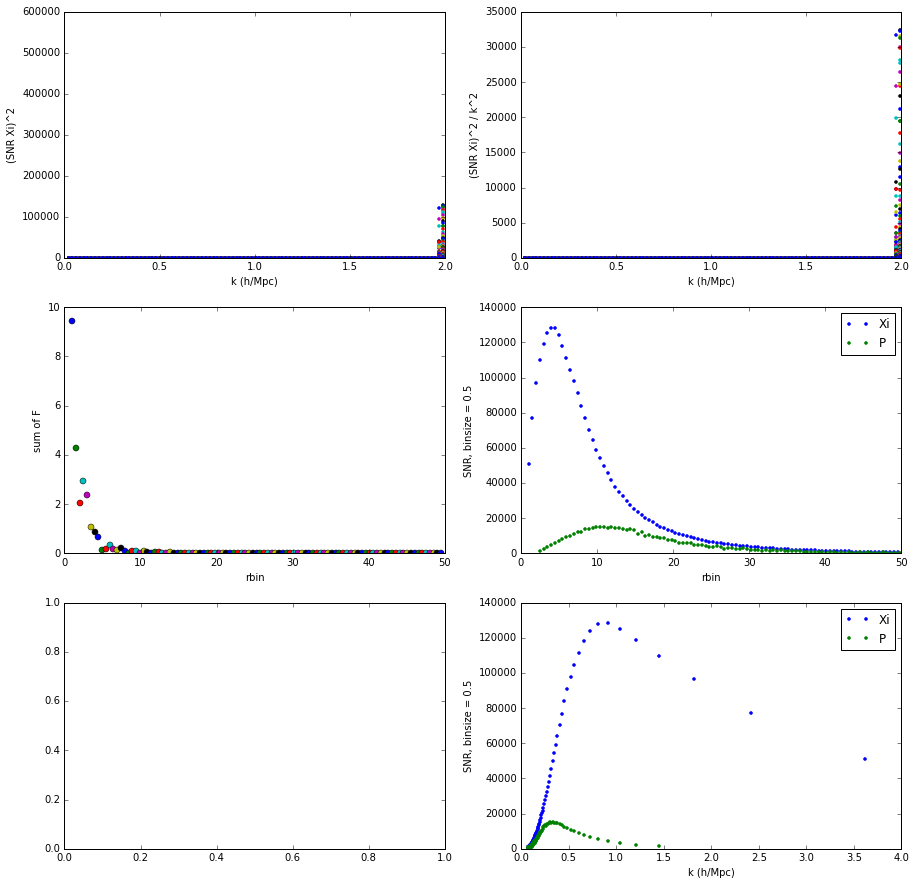

In [380]:
sumSNRXis = [SNRXis_list[i][-1] for i in range(len(SNRXis_list))]
sumSNRs = [SNRs_list[i][-1] for i in range(len(SNRs_list))]
print np.sum(sumSNRs), np.sum(sumSNRXis)

kkk1 = 1.15 * np.pi /rrr1[:-1]

fig, ((ax, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15,15))
for i in range(0, rrr1.size-1):
    ax.plot(ks_x_list[i], SNRXis_list[i], '.', label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
    ax2.plot(ks_x_list[i], SNRXis_list[i]/ks_x_list[i]**2, '.', label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
    ax3.plot(rrr1[i], sum_list[i], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
    #ax4.plot(rrr1[i], SNRXis_list[i][-1], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
    
    #kkk1 = 1.15 * np.pi / rrr1[i]
    #ax6.plot(kkk1, SNRXis_list[i][-1], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
    #ax6.plot(ks_list[i], SNRs_list[i][-1], 'o',label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))

ax4.plot(rrr1[:-1], sumSNRXis, marker = '.', linestyle = '', label = 'Xi')
ax4.plot(rrr1[::-1][:-3], sumSNRs, '.', label = 'P')
ax6.plot(kkk1, sumSNRXis, '.', label = 'Xi')
ax6.plot(kkk[:-3], sumSNRs, '.', label = 'P')
    
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('k (h/Mpc)')
ax2.set_xlabel('k (h/Mpc)')
ax3.set_xlabel('rbin')
ax4.set_xlabel('rbin')
ax6.set_xlabel('k (h/Mpc)')
ax.set_ylabel('(SNR Xi)^2')
ax2.set_ylabel('(SNR Xi)^2 / k^2')
ax3.set_ylabel('sum of F')
ax4.set_ylabel('SNR, binsize = 0.5')
ax6.set_ylabel('SNR, binsize = 0.5')
ax.set_title('')
ax2.set_title('')
#ax.set_xlim(8,10)
#ax2.set_xlim(1.6,2)
ax.set_ylim(0,600000)
ax2.set_ylim(0,)
#ax2.set_ylim(0,2000)
#ax3.set_xlim(-1,i+1)
#ax4.set_xlim(-1,i+1)
#ax.legend(loc='best')
#ax2.legend(loc='best')
#ax3.legend(loc='best')
ax4.legend(loc='best')
ax6.legend(loc='best')
figname = 'figure/DeltaSNR_fixRrange.png'
fig.savefig(figname)
print 'fig save to ',figname



IndexError: index 8 is out of bounds for axis 0 with size 8

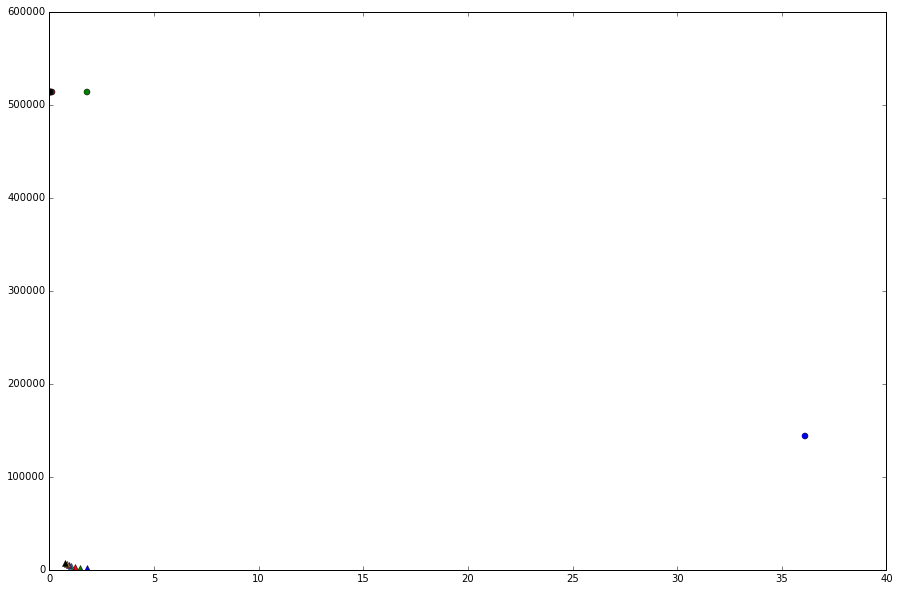

In [334]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
for i in range( kkk.size-1):
    ax.plot(kkk[::-1][i], SNRs_list[::-1][i][-1], '^', label = 'r {}-{}'.format(rrr1[i], rrr1[i+1])) #ax.lines[-1].get_color())
    kkk1 = 1.15 * np.pi / rrr1[i]
    ax.plot(kkk1, SNRXis_list[i][-1], marker = 'o', color = ax.lines[-1].get_color() ,label = 'r {:>0.1f}-{:>0.1f}'.format(rrr1[i], rrr1[i+1]))
    
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('k (h/Mpc)')
ax.set_ylabel('Delta (SNR Xi)^2 / k^2')
ax.set_title('SNR P (dashed) Xi(solid)')
ax.set_xlim(0.01,1)
#ax.set_ylim(0, 3)
#ax.legend(loc='best')
#figname = 'figure/DeltaSNR_r.png'
#fig.savefig(figname)
#print 'fig save to ',figname

----

In [ ]:
# rN = 300, RMAX = 180
# kN SNR P         SNR Xi
# 50 514420.099245 513410.403966
# 60 515327.560728 511095.322897
# 70 515957.564836 512563.69847
# 80 516194.727507 512966.360171
# 90 516605.333565 513925.203867

In [ ]:
# rN = 300, RMAX = 180
# RMAX SNR P         SNR Xi
# 180 516605.333565 513925.203867
# 200 516605.333565 513560.465386
# 300 516605.333565 511052.374183
# 400 516605.333565 508589.227544
# 500 516605.333565 504470.349121

In [ ]:
# same dr
# 
# RMAX SNR P         SNR Xi
# 200 516605.333565 510967.178963
# 300 516605.333565 511052.374183
# 400 516605.333565 512131.031363
# 500 516605.333565 512148.715626

In [ ]:
#kN_y = [50, 60, 70, 80, 90, 100]
kN_y = 100
#rN = 300
rN = [200, 300, 400, 500]
#RMAX = 180.
RMAX = [200, 300, 400, 500]

In [ ]:
for R in RMAX:
    RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, R, kN, R, kN_x, kN_y, logscale = False)
    m_P10, m_P_all10, re_FisherBand_P_all10,re_FisherBand_P10, re_FisherBand_Xi10, re_FisherBand_tot10 \
    = BandPowerFisher(RSDPower)
    sp = np.dot(np.dot(m_P_all10, re_FisherBand_P_all10), m_P_all10.T)
    sx = np.dot(np.dot(m_P_all10, re_FisherBand_Xi10), m_P_all10.T)
    print sp, sx

### Change num of bins

In [ ]:
kN_y = [100, 300, 500]
kkk = np.linspace(KMIN, KMAX, 20)
kkk2 = np.linspace(KMIN, KMAX, 50)
#RSDclass = []

fig, ax = plt.subplots(3,1, figsize=(15,30))
ax = ax.ravel()
for i in range(len(kN_y)): 
    
    RSDclass = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, kN_y[i], logscale = False)
    m_P, m_P_all, re_FisherBand_P_all, re_FisherBand_P, \
    re_FisherBand_Xi, re_FisherBand_tot = BandPowerFisher(RSDclass)

    for j in range(kkk.size -1):   
        ks, SNRs = DeltaCumulativeSNR(RSDclass, re_FisherBand_P, m_P_all, kkk[j], kkk[j+1])
        _, SNRXis = DeltaCumulativeSNR(RSDclass, re_FisherBand_Xi, m_P_all, kkk[j], kkk[j+1])
        ax[i].plot(ks, SNRs/ks**2, linestyle='--', color = 'black' )
        ax[i].plot(ks, SNRXis/ks**2, linestyle='-', color = 'black' ) #ax.lines[-1].get_color())

    for k in range(kkk2.size -1):   
        ks, SNRs = DeltaCumulativeSNR(RSDclass, re_FisherBand_P, m_P_all, kkk2[k], kkk2[k+1])
        _, SNRXis = DeltaCumulativeSNR(RSDclass, re_FisherBand_Xi, m_P_all, kkk2[k], kkk2[k+1])
        ax[i].plot(ks, SNRs/ks**2, linestyle='--', color = 'blue' )
        ax[i].plot(ks, SNRXis/ks**2, linestyle='-', color = 'blue' ) #ax.lines[-1].get_color())


    #ax[i].set_yscale('log')
    #ax.set_xscale('log')
    ax[i].set_xlabel('k (h/Mpc)')
    ax[i].set_ylabel('Delta (SNR Xi)^2 / k^2')
    ax[i].set_title('SNR P (dashed) Xi(solid)')
    ax[i].set_xlim(0,1)
    ax[i].legend(loc='best')
    ax[i].set_title( 'dk = {:>0.3f}'.format(RSDclass.dk_y))
    
figname = 'figure/DeltaSNR.png'
fig.savefig(figname)
print 'fig save to ',figname

## Change range of r

In [ ]:
kN_y = 200
RMIN = 10
RMAX = 180

kmin = .01
kmax = 0.2

In [ ]:
RSDPower_r = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, kN_y, logscale = False)
m_P, m_P_all, re_FisherBand_P_all, re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot = \
BandPowerFisher(RSDPower_r, RMIN = RMIN, RMAX = RMAX, kmin = kmin, kmax = kmax)

In [ ]:
print np.sum(re_FisherBand_Xi)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

#kkk = np.logspace(np.log10(KMIN), np.log10(KMAX), 10)
kkk = np.linspace(KMIN, KMAX, 5)

for i in range(kkk.size -1):   
    ks, SNRs = DeltaCumulativeSNR(RSDPower_r, re_FisherBand_P_all, m_P_all, kkk[i], kkk[i+1])
    _, SNRXis = DeltaCumulativeSNR(RSDPower_r, re_FisherBand_Xi, m_P_all, kkk[i], kkk[i+1])
    ax.plot(ks, SNRs/ks**2, linestyle='--', color = 'black')
    ax.plot(ks, SNRXis/ks**2, linestyle='-', color = 'black') #ax.lines[-1].get_color())
"""
#kkk2 = np.logspace(np.log10(KMIN), np.log10(KMAX), 50)
kkk2 = np.linspace(KMIN, KMAX, 20)
for i in range(kkk2.size -1):   
    ks, SNRs = DeltaCumulativeSNR(RSDPower_r, re_FisherBand_P_all, m_P_all, kkk2[i], kkk2[i+1])
    _, SNRXis = DeltaCumulativeSNR(RSDPower_r, re_FisherBand_Xi, m_P_all, kkk2[i], kkk2[i+1])
    ax.plot(ks, SNRs, linestyle='--', color = 'blue')
    ax.plot(ks, SNRXis, linestyle='-', color = 'blue' ) #ax.lines[-1].get_color())
"""
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('k (h/Mpc)')
ax.set_ylabel('Delta (SNR Xi)^2 / k^2')
ax.set_title('SNR P (dashed) Xi(solid), Rmin = {:>0.2f}, Rmax = {:>0.2f}'.format(RSDPower_r.RMIN, RSDPower_r.RMAX))
ax.set_xlim(0,2)
ax.legend(loc='best')
figname = 'figure/DeltaSNR_r.png'
fig.savefig(figname)
print 'fig save to ',figname

### conergence test

In [ ]:
#  (parameter description in class code)
# Fourier K 0.001~10
KMIN = 0.01
KMAX = 2 # 361.32 #502.32
RMIN = 0.1
RMAX = 180

kmin = 0.01
kmax = 2

# the number of k sample point should be 2^n+1 (b/c romb integration)
rN = 500
kN = 1
kN_x = 2**13 + 1
kN_y = None
#subN = 2**5 + 1
# RSD class

In [ ]:
FP = []
FXI = []

In [ ]:
#kN_y = [50, 100, 200, 300, 400, 500 ] #, 
kN_y = [600, 700, 800, 900, 1000]
for k in kN_y:

    RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, 300, kN_x, k, logscale = False)
    m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot \
    = BandPowerFisher(RSDPower)
    print re_FisherBand_P_all.max(), re_FisherBand_P_all.min()
    print re_FisherBand_Xi.max(), re_FisherBand_Xi.min()
    print np.sum(re_FisherBand_P_all), np.sum(re_FisherBand_Xi)
    FP.append(np.sum(re_FisherBand_P_all))
    FXI.append(np.sum(re_FisherBand_Xi))
    
    fig, (ax, ax2) = plt.subplots(1,2, figsize = (20, 10))
    ax.imshow(re_FisherBand_P_all, interpolation = 'none')
    ax2.imshow(re_FisherBand_Xi,interpolation = 'none', vmin=re_FisherBand_P_all.min(), vmax=re_FisherBand_P_all.max())

In [ ]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (20, 10))
ax.imshow(re_FisherBand_P_all, interpolation = 'none')
ax2.imshow(re_FisherBand_Xi,interpolation = 'none', vmin=re_FisherBand_P_all.min(), vmax=re_FisherBand_P_all.max())
print np.sum(re_FisherBand_P_all), np.sum(re_FisherBand_Xi)

In [ ]:
kN_y = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900]
print FP/FP[-1]
print FXI/FXI[-1]
fig, ax = plt.subplots()
ax.plot( kN_y, FP/FP[-1], 'o-', label = 'P')
ax.plot( kN_y, FXI/FXI[-1], 'o-', label = 'XI')

ax.set_title('convergence check, rN = 300')
ax.set_xlabel(' kN ')
ax.set_ylabel(' sum of Fisher ')
ax.legend(loc='best')

In [330]:
ks_x_list = []
SNRXis_list = []
sum_list = []

RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, fixrn, kN_x, 500, logscale = False)
m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot = \
BandPowerFisher(RSDPower, RMIN = RMIN, RMAX =RMAX , kmin = kmin, kmax = kmax)
    
for i in range(rrr1.size -1):    


    #ks_x, SNRXis = DeltaCumulativeSNR(RSDPower6, re_FisherBand_Xi, m_P_all_xi, kmin, kmax)
    sum_list.append(np.sum(re_FisherBand_Xi))
    ks_x_list.append(ks_x)
    SNRXis_list.append(SNRXis)
    #ax.plot(ks, SNRs/ks**2, linestyle='--', color = 'blue' )

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 9, N_x = 8193
dr = 0.2375, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.3375 1.7625


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 149, N_x = 8193
dr = 0.20259009009, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.30259009009 29.8807432432


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 299, N_x = 8193
dr = 0.201230425056, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.301230425056 59.8654362416


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 449, N_x = 8193
dr = 0.20078125, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.30078125 89.84921875


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 599, N_x = 8193
dr = 0.200557413601, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.300557413601 119.83277592


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 749, N_x = 8193
dr = 0.200423351159, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.300423351159 149.816243316


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 70, rN = 899, N_x = 8193
dr = 0.200334075724, dk=nan, dk_y=0.0288405797101
rcut_min, rcut_max  0.300334075724 179.799665924


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte

multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 33 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 67 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/inte